# Digit Eye


In [15]:
%load_ext autoreload
%autoreload 2
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pickle
import os

from torch.utils.data import DataLoader, Dataset

from src.models import Cifar10Model, ResNet18_32x32, SimpleNet_32x32
from src.models.common.types import EpochResult

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
transform_normalization = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transform_normalization,
    ]
)
test_transform = transforms.Compose([transforms.ToTensor(), transform_normalization])

train_set = torchvision.datasets.CIFAR10(
    root="./assets/data", train=True, download=True, transform=train_transform
)
test_set = torchvision.datasets.CIFAR10(
    root="./assets/data", train=False, download=True, transform=test_transform
)
test_set, validation_set = torch.utils.data.random_split(test_set, (5000, 5000))


batch_size = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(
    dataset=validation_set, batch_size=batch_size, shuffle=False
)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
simple_net_path = "./assets/models/digit_eye_simplenet"
simple_net_model = Cifar10Model(path=simple_net_path, model = SimpleNet_32x32)

res_net_path = "./assets/models/digit_eye_resnet18"
res_net_model = Cifar10Model(path = res_net_path, model = ResNet18_32x32)

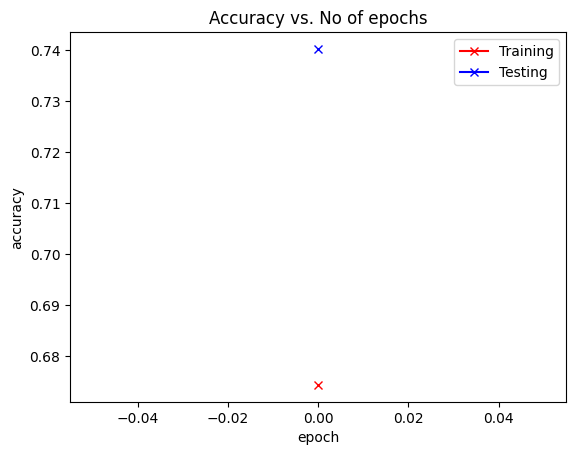

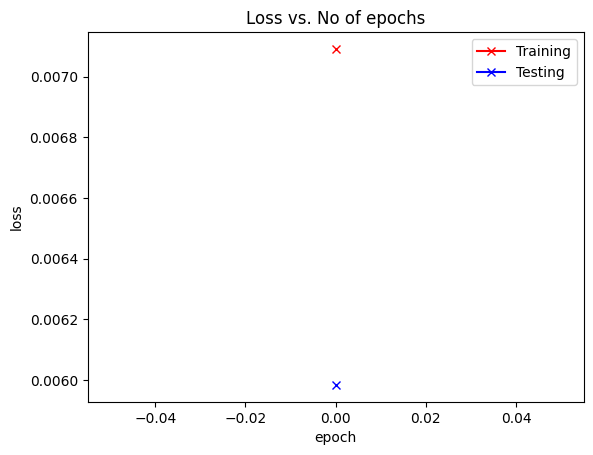

In [21]:
def plot_accuracies(history: list[EpochResult]):
    testing_accuracies = [x["testing"]["accuracy"] for x in history]
    training_accuracies = [x["training"]["accuracy"] for x in history]

    plt.figure()
    plt.plot(training_accuracies, "-rx")
    plt.plot(testing_accuracies, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(["Training", "Testing"])
    plt.title("Accuracy vs. No of epochs")


def plot_losses(history: list[EpochResult]):
    training_losses = [x["training"]["average_loss"] for x in history]
    testing_losses = [x["testing"]["average_loss"] for x in history]

    plt.figure()
    plt.plot(training_losses, "-rx")
    plt.plot(testing_losses, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Testing"])
    plt.title("Loss vs. No of epochs")


def get_history_path(model: Cifar10Model):
    return f"./assets/histories/{type(model.inner_model).__name__}"


def plot_statistics(model: Cifar10Model):
    history_path = get_history_path(model)
    if os.path.isfile(history_path):
        with open(history_path, "rb") as file:
            history: list[EpochResult] = pickle.load(file)

            plot_accuracies(history)
            plot_losses(history)


def train_model(model: Cifar10Model, epochs: int = 10):
    history_path = get_history_path(model)
    history = model.train(
        epochs=epochs, train_loader=train_loader, test_loader=test_loader
    )

    with open(history_path, "wb") as file:
        pickle.dump(history, file)


#simple_net_model.load_weights()
train_model(simple_net_model, epochs = 1)
plot_statistics(simple_net_model)

In [ ]:
#res_net_model.load_weights()
train_model(res_net_model)
plot_statistics(res_net_model)


Validation loss: 0.005944200575351715	Accuracy: 0.7406


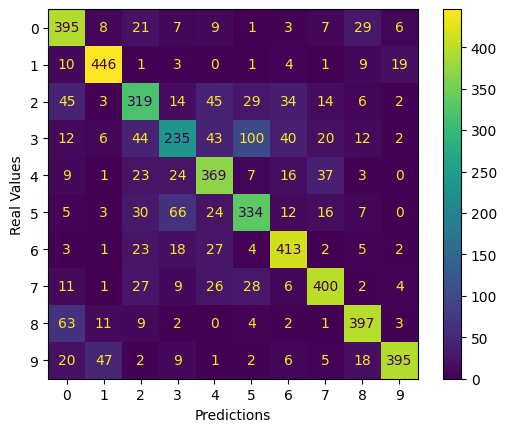


Validation loss: 0.01843094606399536	Accuracy: 0.0966


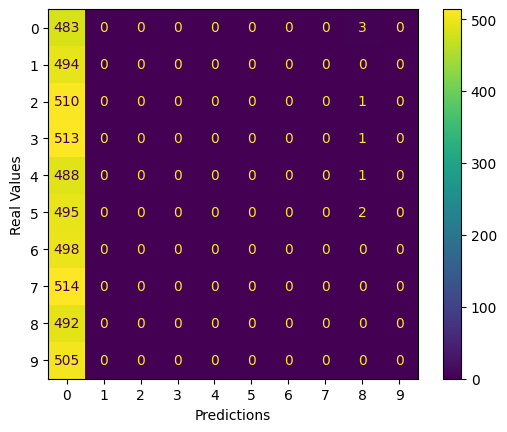

In [23]:
def plot_preds(model: Cifar10Model):
    y_pred = []
    y_true = []

    model.inner_model.eval()
    for batch in validation_loader:
        batch_step = model.batch_step(batch)
        y_pred.extend(batch_step["preds"])
        y_true.extend(batch[1].data)

    y_pred = [y.item() for y in y_pred]
    y_true = [y.item() for y in y_true]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    plt.xlabel("Predictions")
    plt.ylabel("Real Values")
    plt.show()

def validate_model(model: Cifar10Model):
    model.evaluate(validation_loader)
    plot_preds(model)

validate_model(simple_net_model)
validate_model(res_net_model)


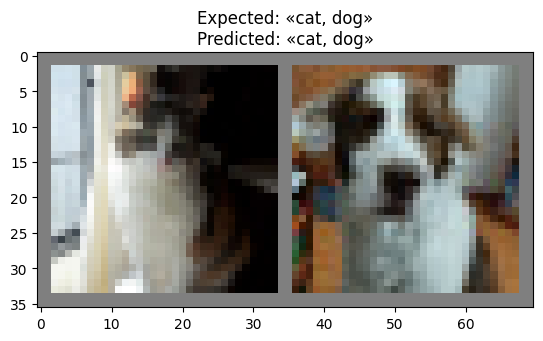

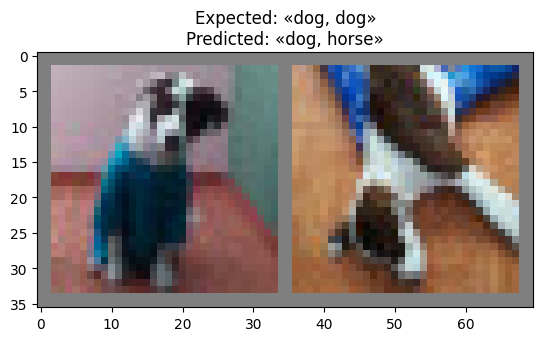

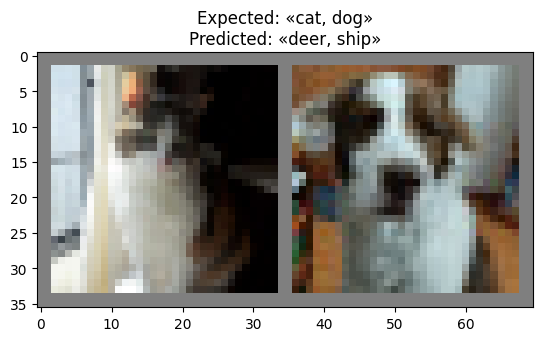

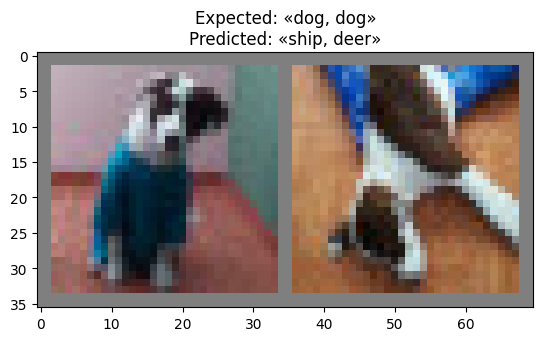

In [22]:
from typing import Dict, List, Tuple


def get_img_title(expected_values: torch.Tensor, predicted_values: torch.Tensor):
    classes: dict[int, str] = dict(map(reversed, train_set.class_to_idx.items()))  # type: ignore
    return f"Expected: «{', '.join(classes[x] for x in expected_values.tolist())}»\nPredicted: «{', '.join(classes[x] for x in predicted_values.tolist())}»"


def imshow(
    img: torch.Tensor, expected_values: torch.Tensor, predicted_values: torch.Tensor
):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.title(get_img_title(expected_values, predicted_values))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class CustomImageFolder(torchvision.datasets.ImageFolder):
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        class_to_idx = {"cat": 3, "dog": 5}
        classes = list(class_to_idx.keys())
        return classes, class_to_idx


custom_set = CustomImageFolder(root="./assets/images", transform=test_transform)
custom_loader = DataLoader(custom_set, batch_size=2)


def custom_validate(model: Cifar10Model):
    for batch in custom_loader:
        images, labels = batch
        batch_step = model.batch_step(batch)
        imshow(torchvision.utils.make_grid(images), labels, batch_step["preds"])


custom_validate(simple_net_model)
custom_validate(res_net_model)
